In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime, timedelta
from tqdm import tqdm

In [120]:
from datetime import datetime, timedelta

# Range date 3 years 
end_date = datetime(2025, 7, 27)
start_date = end_date - timedelta(days=3*365)

# Date List
dates = [
    f"{(start_date + timedelta(days=i)).year}-{(start_date + timedelta(days=i)).month}-{(start_date + timedelta(days=i)).day}"
    for i in range((end_date - start_date).days + 1)
]

In [5]:
!pip install ipywidgets --quiet

In [607]:
base_url = "https://horoskopy.gazeta.pl/horoskop/ryby/dzienny/"

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/115.0 Safari/537.36'
}

data = []

for date in tqdm(dates):
    url = base_url + date
    response = requests.get(url, headers=headers)
    
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')
        try:
            horoskop_text = soup.find("p", class_="lead").get_text(strip=True)
        except AttributeError:
            horoskop_text = None
    else:
        horoskop_text = None

    data.append({'date': date, 'horoscope': horoskop_text})



100%|██████████| 1096/1096 [07:33<00:00,  2.41it/s]


In [608]:
df = pd.DataFrame(data)
df['date'] = pd.to_datetime(df['date'])
df = df.dropna().reset_index(drop=True)

# Save
df.to_excel("horoscope_pisces_3years.xlsx", index=False)
df.head()

,date,horoscope
0,2022-07-28,Ryby spełnią swoje marzenia i pragnienia. Nie ...
1,2022-07-29,Ryby od rana będą pełne sił i energii. Dzień s...
2,2022-07-30,Ryby poczują się trochę osłabione. Dzień nie s...
3,2022-07-31,Ryby będą niechętnie nowym sprawom i znajomośc...
4,2022-08-01,Ryby ogarnie buntowniczy nastrój. Pod byle pre...


In [609]:
# Read
df = pd.read_excel('horoscope_pisces_3years.xlsx')

In [610]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from deep_translator import GoogleTranslator

# Initialization of sentiment analyzer and translator
analyzer = SentimentIntensityAnalyzer()
translator = GoogleTranslator(source='pl', target='en')

# Translating and analyzing function
def translate_and_analyze(text):
    try:
        translated = translator.translate(text)
        sentiment = analyzer.polarity_scores(translated)
        return translated, sentiment['compound']
    except Exception as e:
        print("Error:", e)
        return None, None

# Applying the function and unpacking into two columns
df[['translated_text', 'sentiment_score']] = df['horoscope'].apply(
    lambda x: pd.Series(translate_and_analyze(x))
)

# Categorization of the result
def classify_sentiment(score):
    if score is None:
        return 'unknown'
    elif score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['sentiment_label'] = df['sentiment_score'].apply(classify_sentiment)

Error: Rybo, skup się bardziej na swoim budżecie. Pomyśl, w jaki sposób możesz lepiej planować swoje wydatki, by w razie nadłych zdarzeń nie wpadać w panikę. Czasem lepiej zamiast na kolejne zakupy wybrać się np. do parku na spacer. --> No translation was found using the current translator. Try another translator?
Error: Rybo, gwiazdy sprzyjają Ci dzisiaj w miłości. Wykorzystaj to, jeśli jesteś na etapie poszukiwań swojej drugiej połówki. Masz dzisiaj szansę na poznanie kogoś ciekawego, z kim mogłabyś lub mógłbyś stworzyć udaną relację. --> No translation was found using the current translator. Try another translator?


In [569]:
len(df)

1091

In [611]:
# Save
df.to_excel("horoscope_pisces_3years_new.xlsx", index=False)
df.head()

,date,horoscope,translated_text,sentiment_score,sentiment_label
0,2022-07-28,Ryby spełnią swoje marzenia i pragnienia. Nie ...,Fish will fulfill their dreams and desires. Yo...,0.9734,positive
1,2022-07-29,Ryby od rana będą pełne sił i energii. Dzień s...,Fish will be full of strength and energy from ...,0.9451,positive
2,2022-07-30,Ryby poczują się trochę osłabione. Dzień nie s...,Fish will feel a little weakened. The day is n...,-0.7004,negative
3,2022-07-31,Ryby będą niechętnie nowym sprawom i znajomośc...,Fish will be reluctant to new matters and acqu...,-0.2431,negative
4,2022-08-01,Ryby ogarnie buntowniczy nastrój. Pod byle pre...,The fish will embrace the rebellious mood. Und...,0.9516,positive


In [527]:
from transformers import pipeline

In [612]:
# Read
df = pd.read_excel('horoscope_pisces_3years_new.xlsx')

In [613]:
# Hugging Face pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model="finiteautomata/bertweet-base-sentiment-analysis")

# Test
df_subset = df.head(1090).copy()

# Tłumaczenie i analiza
def translate_and_classify(text):
    try:
        translated = GoogleTranslator(source='pl', target='en').translate(text)
        sentiment = sentiment_pipeline(translated)[0]['label']
        return sentiment
    except Exception as e:
        print("Error:", e)
        return 'unknown'

df_subset['hf_sentiment'] = df_subset['horoscope'].apply(translate_and_classify)

# Results
print(df_subset['hf_sentiment'].value_counts())

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Device set to use cpu


hf_sentiment
POS    596
NEU    398
NEG     96
Name: count, dtype: int64


In [614]:
# Save
df_subset.to_excel("horoscope_pisces_3years_hf.xlsx", index=False)
df_subset.head()

,date,horoscope,translated_text,sentiment_score,sentiment_label,hf_sentiment
0,2022-07-28,Ryby spełnią swoje marzenia i pragnienia. Nie ...,Fish will fulfill their dreams and desires. Yo...,0.9734,positive,POS
1,2022-07-29,Ryby od rana będą pełne sił i energii. Dzień s...,Fish will be full of strength and energy from ...,0.9451,positive,POS
2,2022-07-30,Ryby poczują się trochę osłabione. Dzień nie s...,Fish will feel a little weakened. The day is n...,-0.7004,negative,NEG
3,2022-07-31,Ryby będą niechętnie nowym sprawom i znajomośc...,Fish will be reluctant to new matters and acqu...,-0.2431,negative,NEU
4,2022-08-01,Ryby ogarnie buntowniczy nastrój. Pod byle pre...,The fish will embrace the rebellious mood. Und...,0.9516,positive,POS


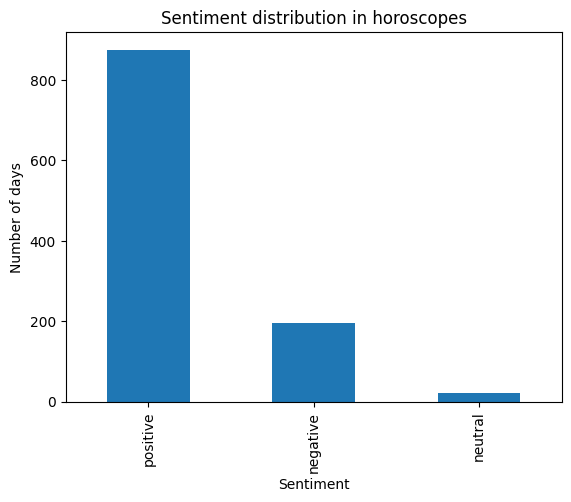

In [615]:
import matplotlib.pyplot as plt

df['sentiment_label'].value_counts().plot(kind='bar', title='Sentiment distribution in horoscopes')
plt.xlabel('Sentiment')
plt.ylabel('Number of days')
plt.show()


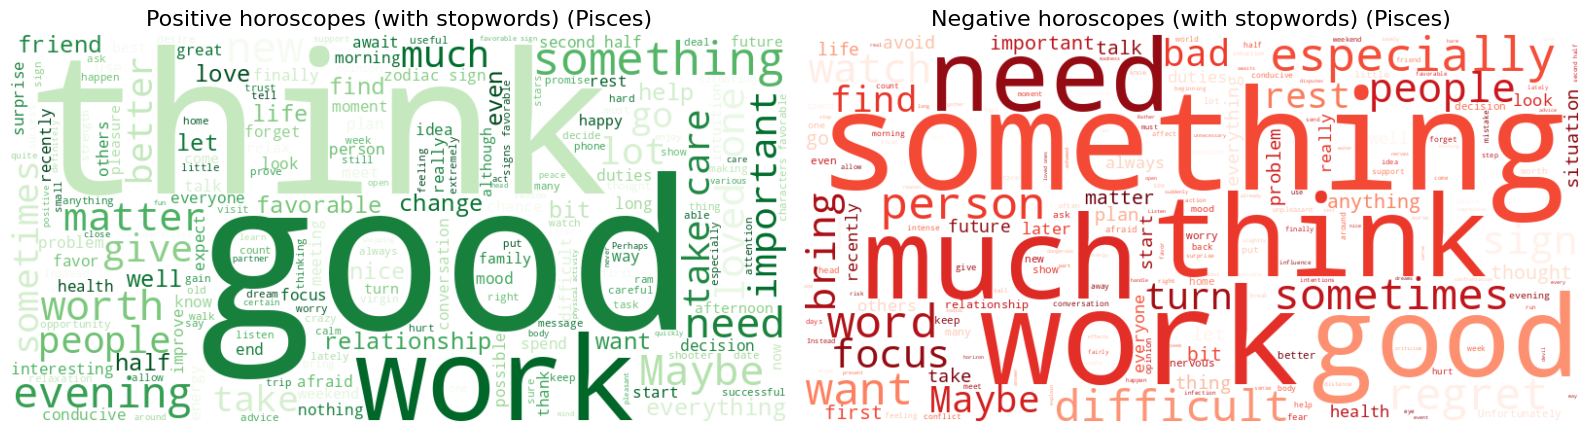

In [617]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Stopwords
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(['Fish','Rybo','Pisces','pisces','Sheep','aries','Aries','Miss','virgo','Virgo','Raku','cancer','Cancer','weight','Wago','libra','Libra','Bull','feel','Bulls','taurus','Taurus','aquarius','Aquarius','scorpio','Scorpio','Scorpion','Scorpions','may','make','Strzelec','Strzelce','Remember','Capricorn','Sagittarius','sagittarius','Lion','Gemini','Twin','twins','Lions', 'today', 'will', 'day', 'time', 'someone', 'try'])

# Text segmentation
positive_texts = " ".join(df[df['sentiment_label'] == 'positive']['translated_text'].tolist())
negative_texts = " ".join(df[df['sentiment_label'] == 'negative']['translated_text'].tolist())

# Creating WordClouds using custom stopwords
wordcloud_pos = WordCloud(width=800, height=400, background_color='white',
                          stopwords=custom_stopwords, colormap='Greens').generate(positive_texts)

wordcloud_neg = WordCloud(width=800, height=400, background_color='white',
                          stopwords=custom_stopwords, colormap='Reds').generate(negative_texts)

# Visualization
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Positive horoscopes (with stopwords) (Pisces)', fontsize=16)

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Negative horoscopes (with stopwords) (Pisces)', fontsize=16)

plt.tight_layout()
plt.savefig("Pisces_wordclouds.png", dpi=300) 
plt.show()


In [619]:
df=df_subset

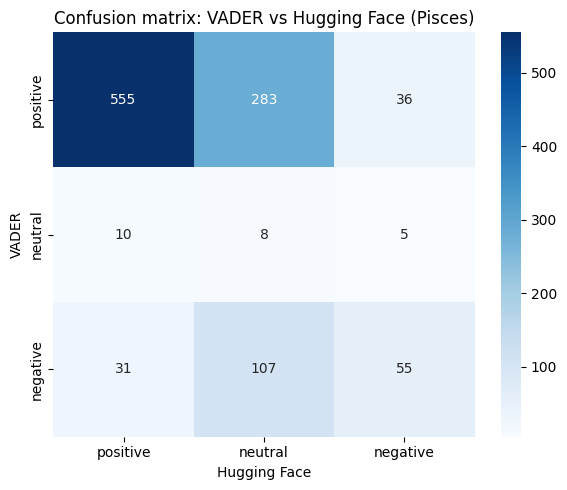

In [620]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Mapping hf_sentiment to full names
hf_map = {
    'POS': 'positive',
    'NEU': 'neutral',
    'NEG': 'negative'
}
df['hf_sentiment_full'] = df['hf_sentiment'].map(hf_map)

# Remove NaN values and ensure all labels are strings
df = df.dropna(subset=['sentiment_label', 'hf_sentiment'])
df['sentiment_label'] = df['sentiment_label'].astype(str)
df['hf_sentiment_full'] = df['hf_sentiment'].map(hf_map).astype(str)

# Confusion matrix
cm = confusion_matrix(df['sentiment_label'], df['hf_sentiment_full'], labels=['positive', 'neutral', 'negative'])

# Heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['positive', 'neutral', 'negative'],
            yticklabels=['positive', 'neutral', 'negative'])
plt.xlabel("Hugging Face")
plt.ylabel("VADER")
plt.title("Confusion matrix: VADER vs Hugging Face (Pisces)")
plt.tight_layout()
plt.savefig("pisces_confusion_matrix.png", dpi=300) 
plt.show()



In [621]:
df

,date,horoscope,translated_text,sentiment_score,sentiment_label,hf_sentiment,hf_sentiment_full
0,2022-07-28,Ryby spełnią swoje marzenia i pragnienia. Nie ...,Fish will fulfill their dreams and desires. Yo...,0.9734,positive,POS,positive
1,2022-07-29,Ryby od rana będą pełne sił i energii. Dzień s...,Fish will be full of strength and energy from ...,0.9451,positive,POS,positive
2,2022-07-30,Ryby poczują się trochę osłabione. Dzień nie s...,Fish will feel a little weakened. The day is n...,-0.7004,negative,NEG,negative
3,2022-07-31,Ryby będą niechętnie nowym sprawom i znajomośc...,Fish will be reluctant to new matters and acqu...,-0.2431,negative,NEU,neutral
4,2022-08-01,Ryby ogarnie buntowniczy nastrój. Pod byle pre...,The fish will embrace the rebellious mood. Und...,0.9516,positive,POS,positive
...,...,...,...,...,...,...,...
1085,2025-07-20,"Rybo, dziś możesz narzekać na swoje samopoczuc...","Fish, today you can complain about your well -...",0.0258,neutral,NEU,neutral
1086,2025-07-21,"Rybo, usłyszysz dziś nieocenioną radę, od osob...","Rybo, you will hear an invaluable advice today...",0.8360,positive,POS,positive
1087,2025-07-22,"Rybo, dziś bądź czujna. Usłyszysz pewną nieoce...","Fish, be alert today. You will hear some inval...",0.4289,positive,POS,positive
1088,2025-07-23,"Rybo, ktoś w Twoim otoczeniu może potrzebować ...","Fish, someone around you may need support. A d...",0.9325,positive,NEU,neutral


In [141]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import nltk
from sklearn.feature_extraction import text

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pmiro\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [622]:
def clean_text(text):
    if not isinstance(text, str):
        return "" 
    text = re.sub(r'[^\w\s]', '', text.lower())
    words = text.split()
    words = [word for word in words if word not in stop_words and len(word) > 2]
    return ' '.join(words)

In [623]:
df['clean_text'] = df['translated_text'].apply(clean_text)

In [624]:
df

,date,horoscope,translated_text,sentiment_score,sentiment_label,hf_sentiment,hf_sentiment_full,clean_text
0,2022-07-28,Ryby spełnią swoje marzenia i pragnienia. Nie ...,Fish will fulfill their dreams and desires. Yo...,0.9734,positive,POS,positive,fish fulfill dreams desires lack intuition pun...
1,2022-07-29,Ryby od rana będą pełne sił i energii. Dzień s...,Fish will be full of strength and energy from ...,0.9451,positive,POS,positive,fish full strength energy morning day favors i...
2,2022-07-30,Ryby poczują się trochę osłabione. Dzień nie s...,Fish will feel a little weakened. The day is n...,-0.7004,negative,NEG,negative,fish feel little weakened day conducive starti...
3,2022-07-31,Ryby będą niechętnie nowym sprawom i znajomośc...,Fish will be reluctant to new matters and acqu...,-0.2431,negative,NEU,neutral,fish reluctant new matters acquaintances becom...
4,2022-08-01,Ryby ogarnie buntowniczy nastrój. Pod byle pre...,The fish will embrace the rebellious mood. Und...,0.9516,positive,POS,positive,fish embrace rebellious mood pretext youll get...
...,...,...,...,...,...,...,...,...
1085,2025-07-20,"Rybo, dziś możesz narzekać na swoje samopoczuc...","Fish, today you can complain about your well -...",0.0258,neutral,NEU,neutral,fish today complain well instead worrying take...
1086,2025-07-21,"Rybo, usłyszysz dziś nieocenioną radę, od osob...","Rybo, you will hear an invaluable advice today...",0.8360,positive,POS,positive,rybo hear invaluable advice today person undou...
1087,2025-07-22,"Rybo, dziś bądź czujna. Usłyszysz pewną nieoce...","Fish, be alert today. You will hear some inval...",0.4289,positive,POS,positive,fish alert today hear invaluable advice initia...
1088,2025-07-23,"Rybo, ktoś w Twoim otoczeniu może potrzebować ...","Fish, someone around you may need support. A d...",0.9325,positive,NEU,neutral,fish someone around may need support delicate ...


In [625]:
# Convert to list
vectorizer = TfidfVectorizer(
    ngram_range=(2, 2),
    stop_words=list(stop_words),  
    min_df=3,
    max_df=0.95
)

# Transformation
tfidf_matrix = vectorizer.fit_transform(df['clean_text'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df['hf_sentiment_full'] = df['hf_sentiment_full'].values

In [626]:
tfidf_df.head(10)

,able interrupt,achieve goals,achieve success,across dishonest,action plan,activity weekend,add additional,additional dose,additional tasks,advance free,...,worth thinking,would like,would work,years ago,youll feel,youll get,youve neglected,zodiac sign,zodiac signs,hf_sentiment_full
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.283648,0.00000,positive
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.219806,0.00000,positive
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.247563,0.00000,negative
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,neutral
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.410322,0.0,0.260043,0.00000,positive
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,neutral
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.214383,0.00000,neutral
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.373493,0.00000,neutral
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.290001,0.00000,neutral
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.34066,positive


In [627]:
def top_bigrams_per_label(label, top_n=10):
    class_rows = tfidf_df[tfidf_df['hf_sentiment_full'] == label].drop(columns='hf_sentiment_full')
    mean_scores = class_rows.mean().sort_values(ascending=False).head(top_n)
    print(f"\nTop {top_n} bigrams for {label}:")
    for phrase, score in mean_scores.items():
        print(f"{phrase} ({score:.4f})")

In [628]:
top_bigrams_per_label('negative')   # Negative horoscope
top_bigrams_per_label('neutral')  # Neutral horoscope
top_bigrams_per_label('positive')  # Positive horoscope


Top 10 bigrams for negative:
fish watch (0.0493)
loved ones (0.0404)
better talk (0.0210)
fish feel (0.0204)
today unfortunately (0.0197)
regret later (0.0191)
rybo today (0.0188)
fish bit (0.0185)
rybo recently (0.0184)
watch words (0.0184)

Top 10 bigrams for neutral:
loved ones (0.0202)
take care (0.0199)
however try (0.0152)
rybo today (0.0151)
fish feel (0.0143)
fish dont (0.0141)
fish today (0.0138)
half day (0.0138)
fish remember (0.0129)
second half (0.0119)

Top 10 bigrams for positive:
rybo today (0.0317)
take care (0.0206)
loved ones (0.0199)
dont afraid (0.0162)
fish today (0.0160)
zodiac sign (0.0147)
long time (0.0144)
half day (0.0127)
second half (0.0121)
good day (0.0118)


In [629]:
df['date'] = pd.to_datetime(df['date'])

# 'Date' as index
df.set_index('date', inplace=True)

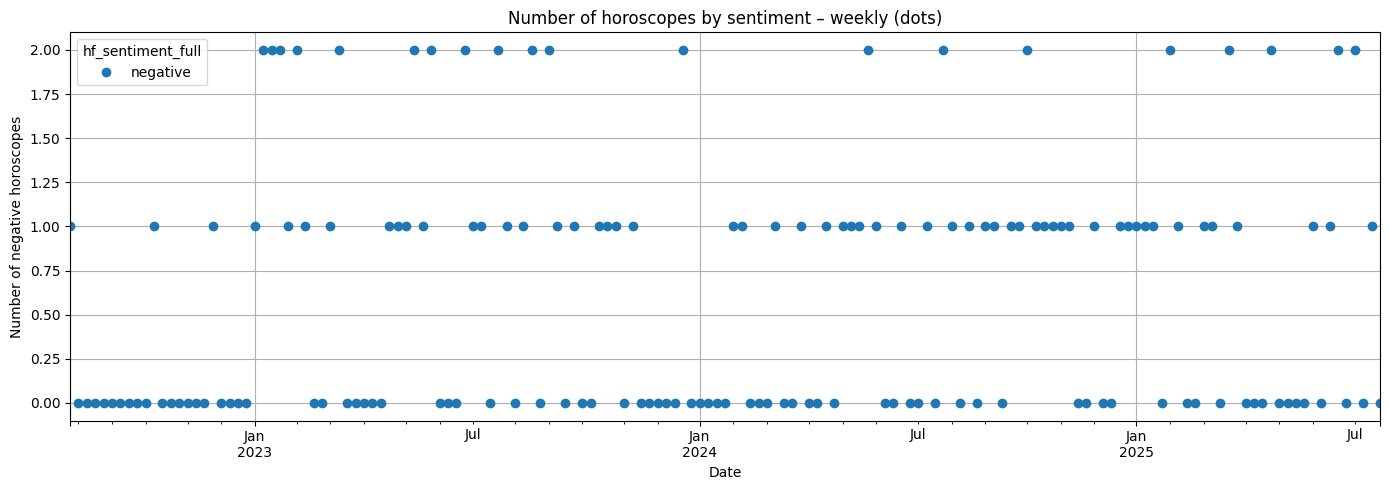

In [630]:
weekly_sentiment = (
    df.groupby([pd.Grouper(freq='W'), 'hf_sentiment_full'])
      .size()
      .unstack(fill_value=0)
)

weekly_sentiment[['negative']].plot(
    figsize=(14, 5), 
    style=['o', 'o', 'o'],  # same kropki, bez linii
    markersize=6,
    grid=True
)

plt.title("Number of horoscopes by sentiment – weekly (dots)")
plt.xlabel("Date")
plt.ylabel("Number of negative horoscopes")
plt.tight_layout()
plt.show()




C:\Users\pmiro\AppData\Local\Temp\ipykernel_32136\3979129097.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.groupby([pd.Grouper(freq='M'), 'hf_sentiment_full'])


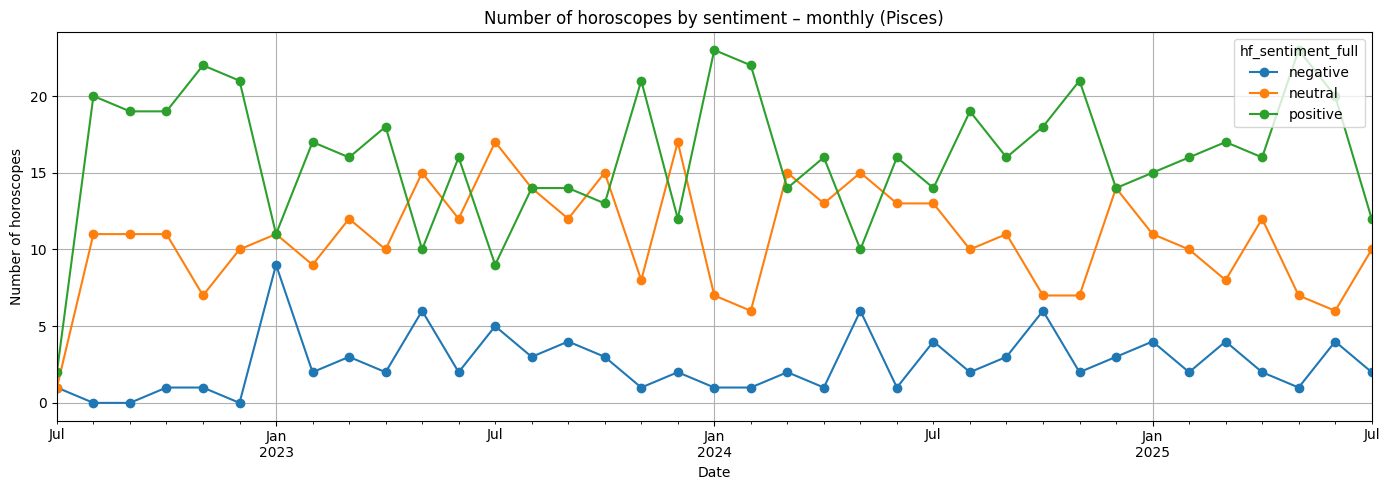

In [631]:
monthly_sentiment = (
    df.groupby([pd.Grouper(freq='M'), 'hf_sentiment_full'])
      .size()
      .unstack(fill_value=0)
)

monthly_sentiment[['negative', 'neutral', 'positive']].plot(figsize=(14, 5), marker='o')
plt.title("Number of horoscopes by sentiment – monthly (Pisces)")
plt.xlabel("Date")
plt.ylabel("Number of horoscopes")
plt.grid(True)
plt.tight_layout()
plt.savefig("pisces_monthly_sentiment.png", dpi=300)  
plt.show()


In [2]:
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt

In [3]:
# 🧾 Wczytaj dane 
files = ["horoscope_pisces_3years_hf.xlsx","horoscope_aries_3years_hf.xlsx","horoscope_virgo_3years_hf.xlsx",
         "horoscope_cancer_3years_hf.xlsx","horoscope_libra_3years_hf.xlsx","horoscope_taurus_3years_hf.xlsx",
         "horoscope_aquarius_3years_hf.xlsx","horoscope_scorpio_3years_hf.xlsx","horoscope_sagittarius_3years_hf.xlsx",
         "horoscope_leo_3years_hf.xlsx",
         "horoscope_gemini_3years_hf.xlsx", "horoskopy_koziorozec_3lata_hf.xlsx"]

source_map = {
    "horoscope_leo_3years_hf.xlsx": "Leo",
    "horoskopy_koziorozec_3lata_hf.xlsx": "Capricorn",
    "horoscope_gemini_3years_hf.xlsx": "Gemini",
    "horoscope_sagittarius_3years_hf.xlsx": "Sagittarius",
    "horoscope_scorpio_3years_hf.xlsx": "Scorpio",
    "horoscope_aquarius_3years_hf.xlsx": "Aquarius",
    "horoscope_taurus_3years_hf.xlsx": "Taurus",
    "horoscope_libra_3years_hf.xlsx": "Libra",
    "horoscope_cancer_3years_hf.xlsx": "Cancer",
    "horoscope_virgo_3years_hf.xlsx": "Virgo",
    "horoscope_aries_3years_hf.xlsx": "Aries",
    "horoscope_pisces_3years_hf.xlsx": "Pisces"
}

df_concat = pd.concat(
    [pd.read_excel(f).assign(source=source_map[f]) for f in files],
    ignore_index=True
)

In [641]:
df_concat

,date,horoscope,translated_text,sentiment_score,sentiment_label,hf_sentiment,source
0,2022-07-28,Ryby spełnią swoje marzenia i pragnienia. Nie ...,Fish will fulfill their dreams and desires. Yo...,0.9734,positive,POS,Pisces
1,2022-07-29,Ryby od rana będą pełne sił i energii. Dzień s...,Fish will be full of strength and energy from ...,0.9451,positive,POS,Pisces
2,2022-07-30,Ryby poczują się trochę osłabione. Dzień nie s...,Fish will feel a little weakened. The day is n...,-0.7004,negative,NEG,Pisces
3,2022-07-31,Ryby będą niechętnie nowym sprawom i znajomośc...,Fish will be reluctant to new matters and acqu...,-0.2431,negative,NEU,Pisces
4,2022-08-01,Ryby ogarnie buntowniczy nastrój. Pod byle pre...,The fish will embrace the rebellious mood. Und...,0.9516,positive,POS,Pisces
...,...,...,...,...,...,...,...
13075,2025-07-22,"Koziorożcu, pamiętaj, że lepsza jest szczera p...","Capricorn, remember that honest truth is bette...",0.9571,positive,POS,Capricorn
13076,2025-07-23,"Koziorożcu, poczujesz się dziś nieco osamotnio...","Capricorn, you will feel a bit lonely today. T...",-0.4621,negative,NEU,Capricorn
13077,2025-07-24,"Koziorożcu, nie przejmuj się opiniami innych i...","Capricorn, do not worry about the opinions of ...",0.0767,positive,POS,Capricorn
13078,2025-07-25,"Koziorożcu, dziś będziesz bardzo ciekawski, a ...","Capricorn, today you will be very curious, and...",-0.3723,negative,NEG,Capricorn


In [634]:
# upewniamy się, że kolumna data jest typu datetime
df_concat["date"] = pd.to_datetime(df_concat["date"], errors='coerce')

In [643]:
# ===== 2) Filtrowanie pozytywnych wpisów =====
# Dostosuj warunek jeśli sentyment jest liczbowy
df_pos = df_concat[df_concat["hf_sentiment"] == "POS"]

In [648]:
# ===== 2) Filtrowanie pozytywnych wpisów =====
# Dostosuj warunek jeśli sentyment jest liczbowy
df_neg = df_concat[df_concat["hf_sentiment"] == "NEG"]

In [645]:
# ===== 3) Grupowanie po znaku i czasie =====
freq = 'ME'  # 'M' = miesiąc, 'W' = tydzień, 'D' = dzień
grouped = (
    df_pos
    .groupby(["source", pd.Grouper(key="date", freq=freq)])
    .size()
    .reset_index(name="liczba_pozytywnych")
)


In [652]:
# ===== 3) Grupowanie po znaku i czasie =====
freq = 'ME'  # 'M' = miesiąc, 'W' = tydzień, 'D' = dzień
grouped_neg = (
    df_neg
    .groupby(["source", pd.Grouper(key="date", freq=freq)])
    .size()
    .reset_index(name="liczba_negatywnych")
)


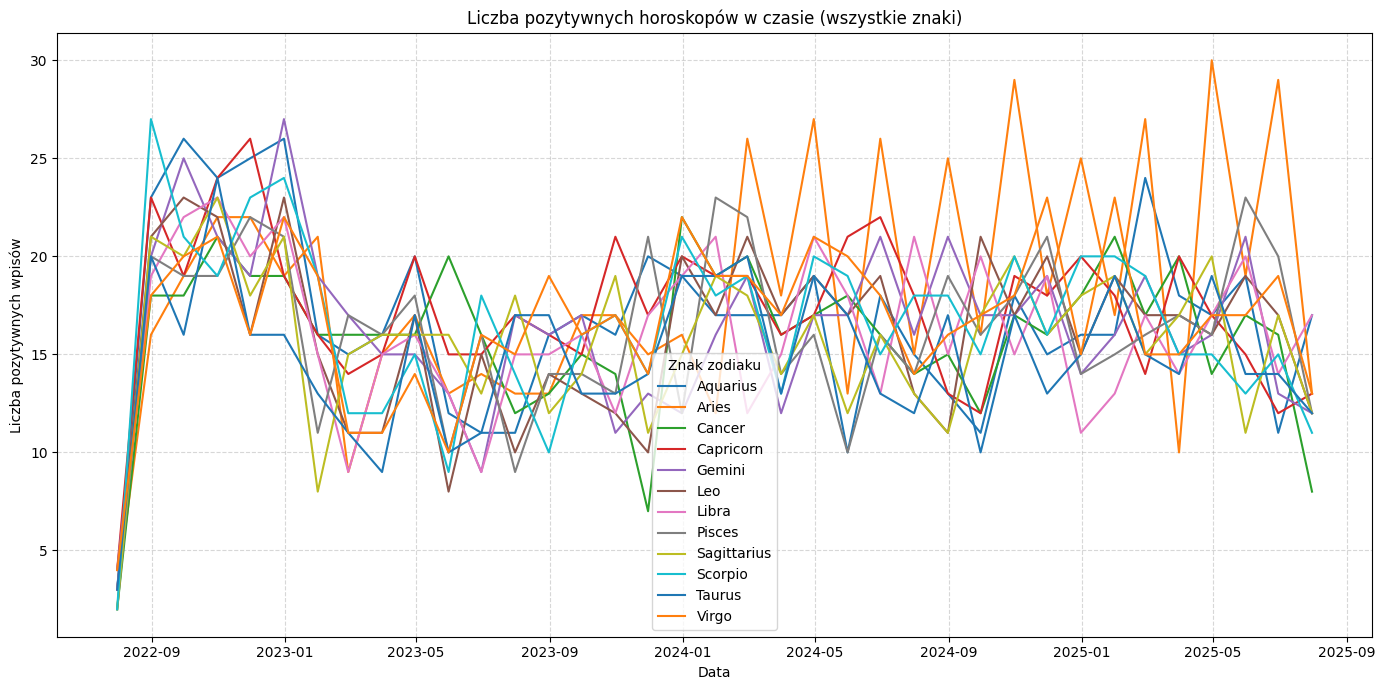

In [655]:
# ===== 4) Pivot i wykres zbiorczy =====
pivot_df = grouped.pivot(index="date", columns="source", values="liczba_pozytywnych").fillna(0)

plt.figure(figsize=(14, 7))
for znak in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[znak], linestyle='-', label=znak)

plt.title("Liczba pozytywnych horoskopów w czasie (wszystkie znaki)")
plt.xlabel("Data")
plt.ylabel("Liczba pozytywnych wpisów")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(title="Znak zodiaku")
plt.tight_layout()
plt.show()

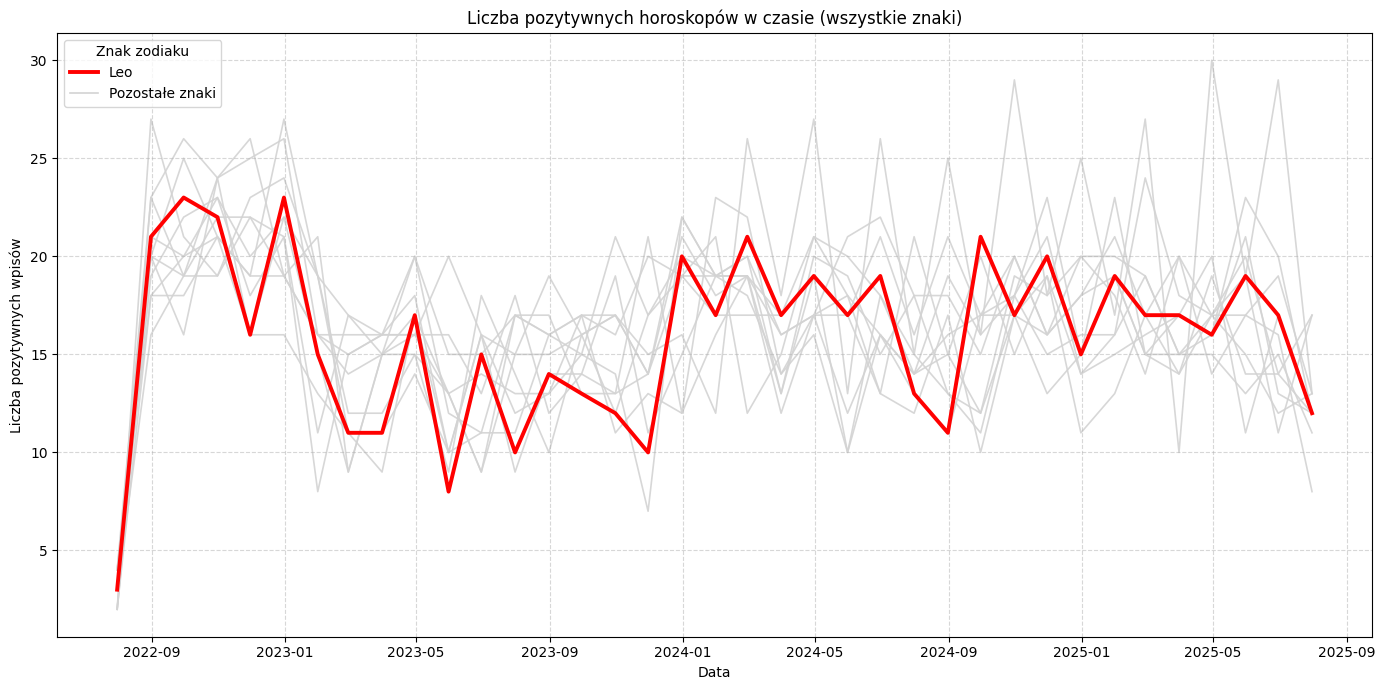

In [790]:
# ===== 4) Pivot i wykres zbiorczy =====
pivot_df = grouped.pivot(index="date", columns="source", values="liczba_pozytywnych").fillna(0)

highlight_sign = "Leo"  # jeśli masz "Lew", zmień na "Lew"

plt.figure(figsize=(14, 7))

for col in pivot_df.columns:
    if str(col).lower() == highlight_sign.lower():
        # linia wyróżniona (Leo)
        plt.plot(
            pivot_df.index, pivot_df[col],
            linestyle='-', linewidth=2.8, color='red', zorder=3, label=str(col)
        )
    else:
        # wszystkie pozostałe na szaro
        plt.plot(
            pivot_df.index, pivot_df[col],
            linestyle='-', linewidth=1.2, color='lightgray', alpha=0.9, zorder=1
        )

plt.title("Liczba pozytywnych horoskopów w czasie (wszystkie znaki)")
plt.xlabel("Data")
plt.ylabel("Liczba pozytywnych wpisów")
plt.grid(True, linestyle="--", alpha=0.5)

# zwięzła legenda: tylko Leo + przykład pozostałych
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='red', linewidth=2.8, label=highlight_sign),
    Line2D([0], [0], color='lightgray', linewidth=1.2, label='Pozostałe znaki')
]
plt.legend(handles=legend_elements, title="Znak zodiaku")

plt.tight_layout()
plt.show()


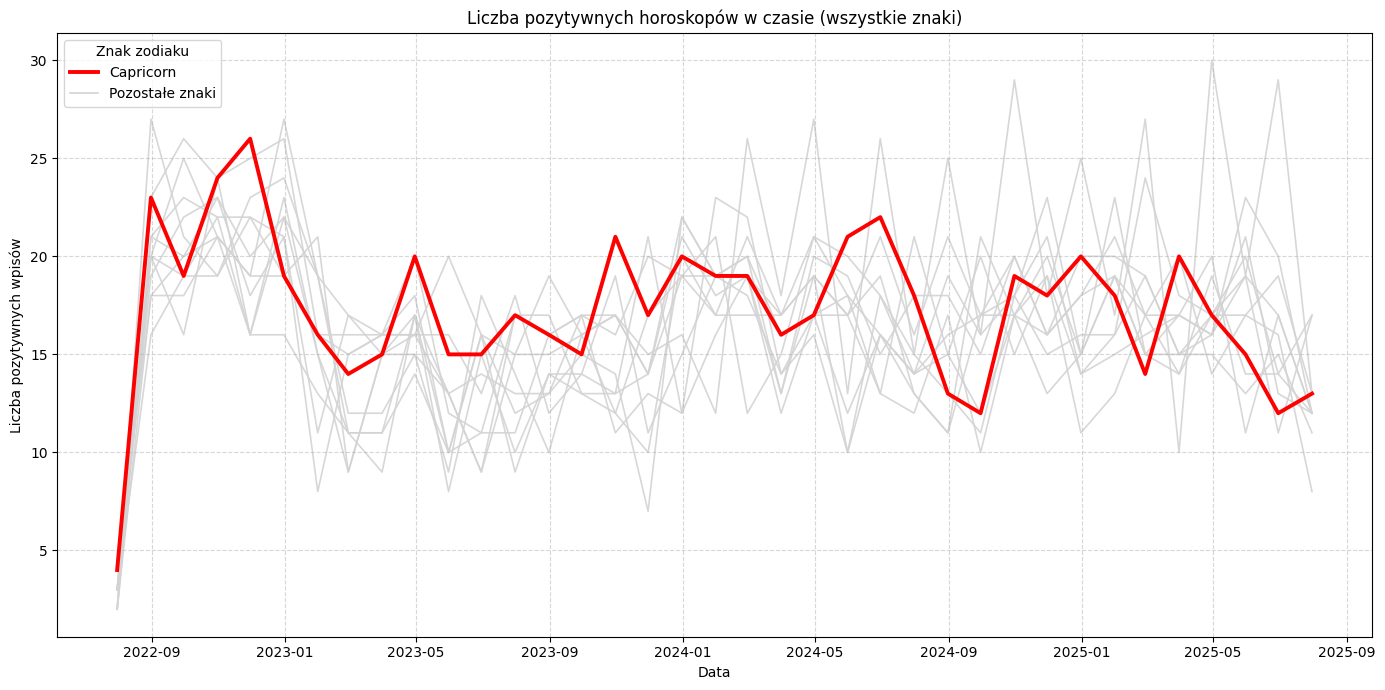

In [791]:
# ===== 4) Pivot i wykres zbiorczy =====
pivot_df = grouped.pivot(index="date", columns="source", values="liczba_pozytywnych").fillna(0)

highlight_sign = "Capricorn"  # jeśli masz "Lew", zmień na "Lew"

plt.figure(figsize=(14, 7))

for col in pivot_df.columns:
    if str(col).lower() == highlight_sign.lower():
        # linia wyróżniona (Leo)
        plt.plot(
            pivot_df.index, pivot_df[col],
            linestyle='-', linewidth=2.8, color='red', zorder=3, label=str(col)
        )
    else:
        # wszystkie pozostałe na szaro
        plt.plot(
            pivot_df.index, pivot_df[col],
            linestyle='-', linewidth=1.2, color='lightgray', alpha=0.9, zorder=1
        )

plt.title("Liczba pozytywnych horoskopów w czasie (wszystkie znaki)")
plt.xlabel("Data")
plt.ylabel("Liczba pozytywnych wpisów")
plt.grid(True, linestyle="--", alpha=0.5)

# zwięzła legenda: tylko Leo + przykład pozostałych
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='red', linewidth=2.8, label=highlight_sign),
    Line2D([0], [0], color='lightgray', linewidth=1.2, label='Pozostałe znaki')
]
plt.legend(handles=legend_elements, title="Znak zodiaku")

plt.tight_layout()
plt.show()

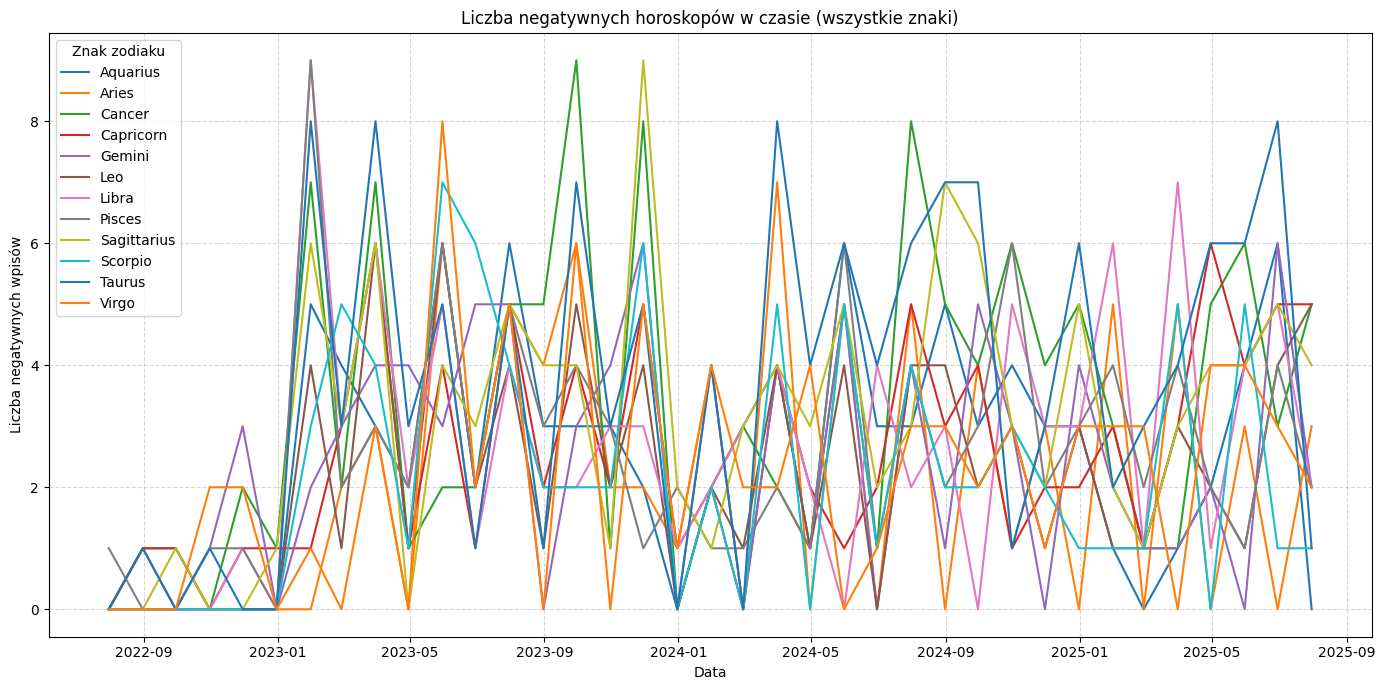

In [654]:
# ===== 4) Pivot i wykres zbiorczy =====
pivot_df = grouped_neg.pivot(index="date", columns="source", values="liczba_negatywnych").fillna(0)

plt.figure(figsize=(14, 7))
for znak in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[znak], linestyle='-', label=znak)

plt.title("Liczba negatywnych horoskopów w czasie (wszystkie znaki)")
plt.xlabel("Data")
plt.ylabel("Liczba negatywnych wpisów")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(title="Znak zodiaku")
plt.tight_layout()
plt.show()

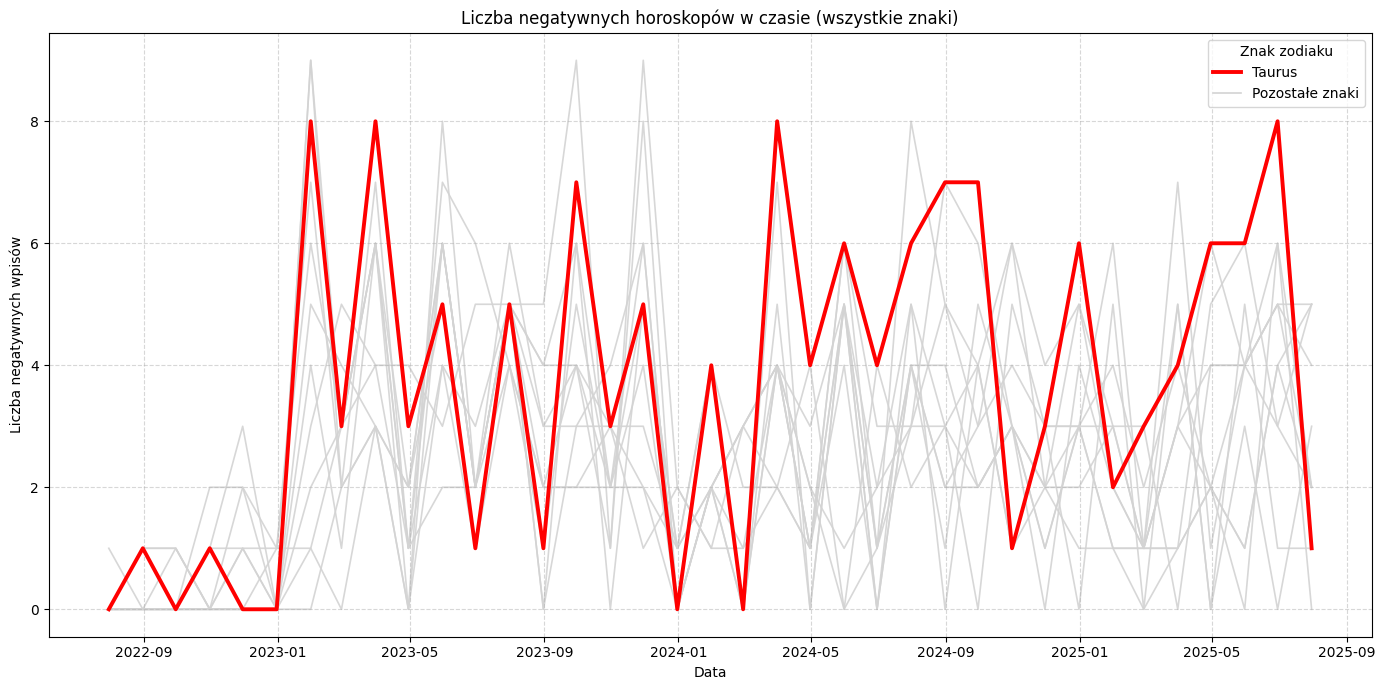

In [801]:
# ===== 4) Pivot i wykres zbiorczy =====
# Upewnij się, że w columns masz kolumnę ze znakiem (np. "sign"), nie "source"
pivot_df = grouped_neg.pivot(index="date", columns="source", values="liczba_negatywnych").fillna(0)

highlight_sign = "Taurus"  # jeśli używasz polskich nazw, zmień na "Lew"

plt.figure(figsize=(14, 7))

found = False
for col in pivot_df.columns:
    if str(col).lower() == highlight_sign.lower():
        plt.plot(
            pivot_df.index, pivot_df[col],
            linestyle='-', linewidth=2.8, color='red', zorder=3, label=str(col)
        )
        found = True
    else:
        plt.plot(
            pivot_df.index, pivot_df[col],
            linestyle='-', linewidth=1.2, color='lightgray', alpha=0.9, zorder=1
        )

plt.title("Liczba negatywnych horoskopów w czasie (wszystkie znaki)")
plt.xlabel("Data")
plt.ylabel("Liczba negatywnych wpisów")
plt.grid(True, linestyle="--", alpha=0.5)

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='red', linewidth=2.8, label=highlight_sign),
    Line2D([0], [0], color='lightgray', linewidth=1.2, label='Pozostałe znaki')
]
plt.legend(handles=legend_elements, title="Znak zodiaku")

plt.tight_layout()
plt.show()


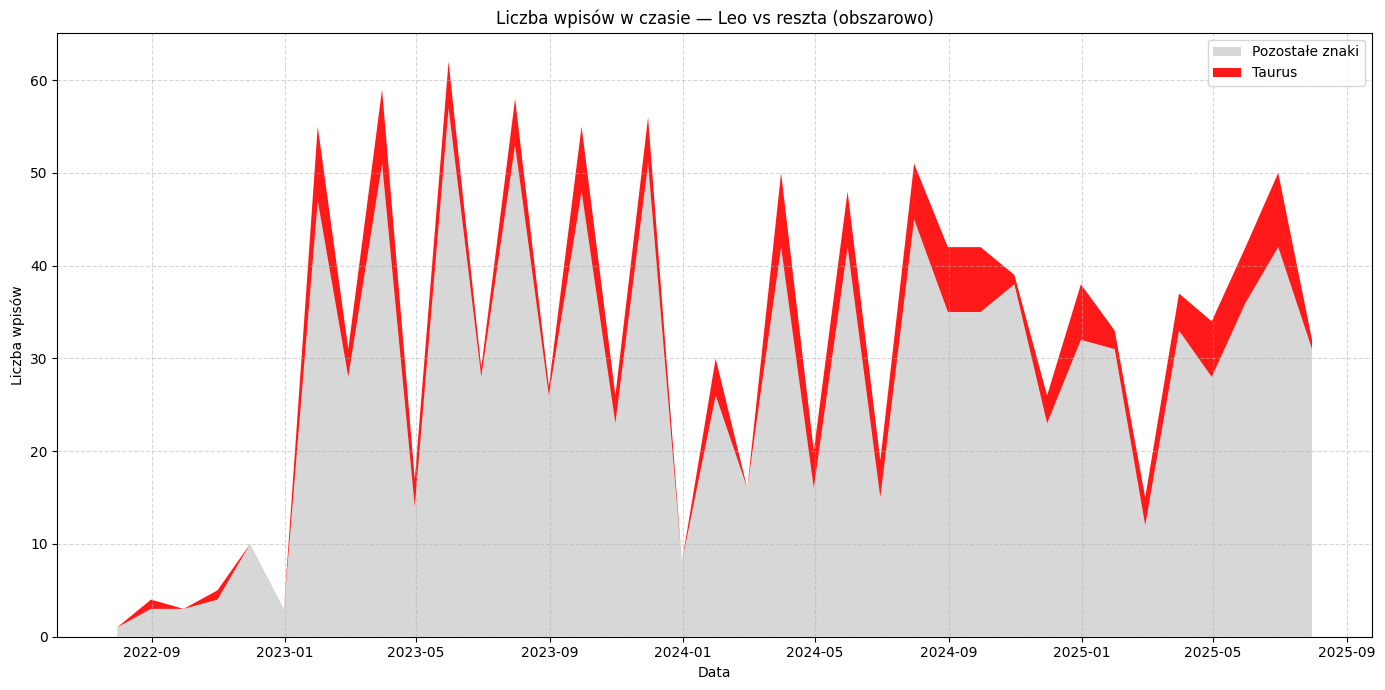

In [802]:
import numpy as np
import matplotlib.pyplot as plt

highlight_sign = "Taurus"  # jeśli masz polskie nazwy, użyj "Lew"

others = pivot_df.drop(columns=[highlight_sign], errors="ignore").sum(axis=1)
if highlight_sign not in pivot_df.columns:
    raise ValueError(f"Nie ma kolumny '{highlight_sign}' w pivot_df.columns: {list(pivot_df.columns)}")

plt.figure(figsize=(14,7))
plt.stackplot(
    pivot_df.index,
    [others.values, pivot_df[highlight_sign].values],
    labels=["Pozostałe znaki", highlight_sign],
    colors=["lightgray", "red"],
    alpha=0.9
)
plt.title("Liczba wpisów w czasie — Leo vs reszta (obszarowo)")
plt.xlabel("Data"); plt.ylabel("Liczba wpisów")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout(); plt.show()


In [592]:
df_concat["hf_sentiment"] = df_concat["hf_sentiment"].map({
    "POS": 0,
    "NEG": 1,
    "NEU": 0
})


📊 Tabela kontyngencji (grupa vs is_negative):
hf_sentiment   0.0  1.0
source                 
Aquarius       996   93
Aries         1012   78
Cancer         966  124
Capricorn      994   94
Gemini        1002   88
Leo           1007   83
Libra          991   99
Sagittarius    973  116
Scorpio       1007   83
Taurus         953  137
Virgo         1007   82


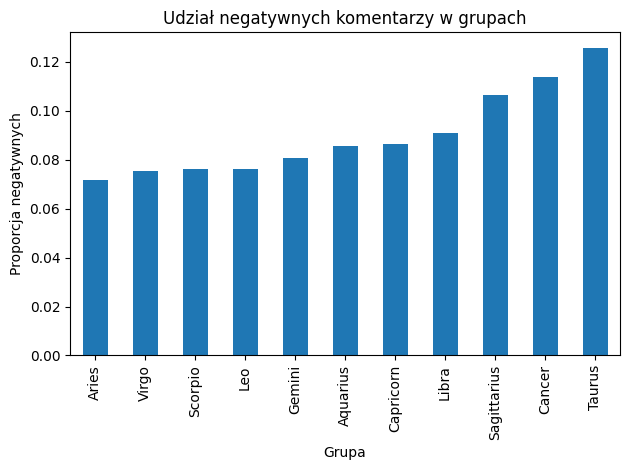


🔬 Test chi-kwadrat:
Chi2 = 42.263, df = 10, p-value = 0.0000
❗ Istnieje istotna statystycznie różnica w proporcji negatywnych komentarzy między grupami.


In [593]:
# kolumny: 'grupa', 'is_negative' (1 = negatywny, 0 = nie)

# 📊 Tabela kontyngencji: liczba negatywnych i nie-negatywnych komentarzy w każdej grupie
contingency = pd.crosstab(df_concat['source'], df_concat['hf_sentiment'])

# 🔍 Wyświetl tabelę (opcjonalnie)
print("\n📊 Tabela kontyngencji (grupa vs is_negative):")
print(contingency)

# 🧪 Test chi-kwadrat
chi2, pval, dof, expected = chi2_contingency(contingency)

# 📈 Wizualizacja proporcji negatywnych komentarzy
proportions = df_concat.groupby('source')['hf_sentiment'].mean().sort_values()
proportions.plot(kind='bar', title='Udział negatywnych komentarzy w grupach')
plt.ylabel('Proporcja negatywnych')
plt.xlabel('Grupa')
plt.tight_layout()
plt.show()

# 📋 Wyniki
print(f"\n🔬 Test chi-kwadrat:")
print(f"Chi2 = {chi2:.3f}, df = {dof}, p-value = {pval:.4f}")

# 📌 Interpretacja
if pval < 0.05:
    print("❗ Istnieje istotna statystycznie różnica w proporcji negatywnych komentarzy między grupami.")
else:
    print("✅ Brak podstaw do odrzucenia hipotezy zerowej – proporcje są podobne.")


In [202]:
import numpy as np
from sentence_transformers import SentenceTransformer, util
import seaborn as sns
import matplotlib.pyplot as plt

In [594]:
# 🎲 Wylosuj 10 horoskopów
sample_df = df_concat['translated_text'].dropna().sample(10).reset_index(drop=True)

In [595]:
sample_df

0    The goal sanctifies the means? If you think so...
1    Bull, Sunday should be quite calm. It's a grea...
2    Someone close to your attention. He is not sur...
3    The weight is looking forward to this day at w...
4    Bull, you have a little more time today, try t...
5    Dreams come true, so allow yourself a weekend ...
6    You definitely spend more than you can. The po...
7    Wago, flirt boldly and take the first step. Th...
8    Women under the sign of Aries have become the ...
9    Lion, today is the perfect day to finally end ...
Name: translated_text, dtype: object

In [596]:
# 🧠 Wczytaj model (obsługuje język polski)
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

# 🔢 Wygeneruj embeddingi dla horoskopów
embeddings = model.encode(sample_df.tolist(), convert_to_tensor=True)

In [597]:
# 🔍 Oblicz macierz podobieństwa kosinusowego
similarity_matrix = util.cos_sim(embeddings, embeddings).cpu().numpy()

# 🏷️ Etykiety: np. pierwsze 5 słów każdego horoskopu
labels = [text[:40] + '...' for text in sample_df]  

In [598]:
# 📊 Stwórz macierz podobieństwa jako DataFrame
similarity_df = pd.DataFrame(similarity_matrix, index=labels, columns=labels)

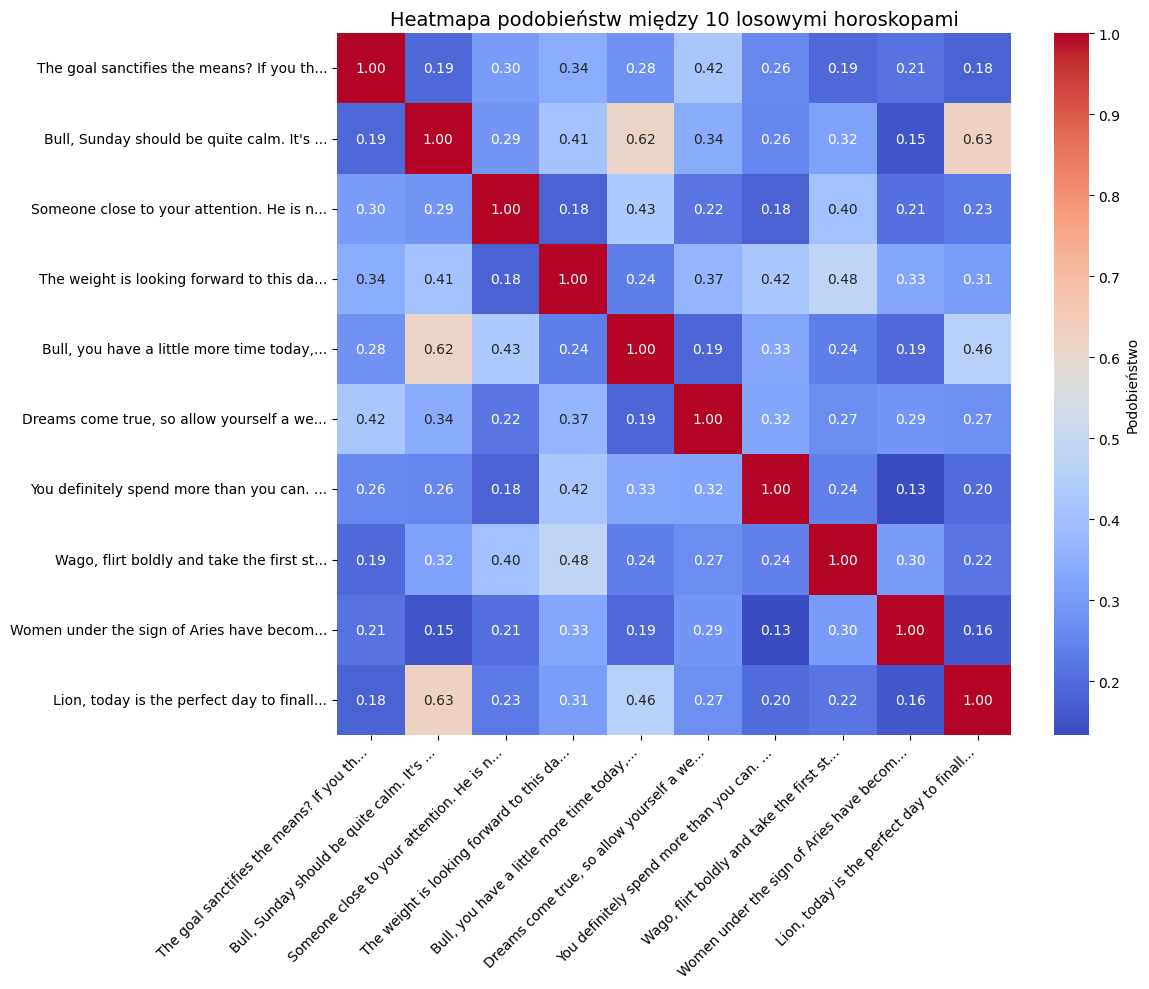

In [599]:
# 🎨 Heatmapa
plt.figure(figsize=(12, 10))
sns.heatmap(similarity_df, annot=True, cmap='coolwarm', fmt=".2f", cbar_kws={'label': 'Podobieństwo'})
plt.title("Heatmapa podobieństw między 10 losowymi horoskopami", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [557]:
from itertools import combinations

In [600]:
# 🔎 Znajdź top 5 najbardziej podobnych par (pomijając przekątne i duplikaty)
pairs = list(combinations(range(len(sample_df)), 2))  # wszystkie unikalne pary indeksów

pair_scores = []
for i, j in pairs:
    pair_scores.append({
        'index_1': i,
        'index_2': j,
        'similarity': similarity_matrix[i][j],
        'horoscope_1': sample_df[i],
        'horoscope_2': sample_df[j]
    })

# Posortuj malejąco wg podobieństwa i wybierz top 5
top_pairs = sorted(pair_scores, key=lambda x: x['similarity'], reverse=True)[:3]

# 📃 Wypisz podobne pary
print("\n🔝 Top 5 najbardziej podobnych par horoskopów:\n")
for idx, pair in enumerate(top_pairs, 1):
    print(f"📌 Para {idx} — Podobieństwo: {pair['similarity']:.3f}")
    print(f"Horoskop 1:\n{pair['horoscope_1']}")
    print(f"Horoskop 2:\n{pair['horoscope_2']}")
    print("-" * 80)


🔝 Top 5 najbardziej podobnych par horoskopów:

📌 Para 1 — Podobieństwo: 0.626
Horoskop 1:
Bull, Sunday should be quite calm. It's a great time to finally rest, gather thoughts and afford blissful laziness. Recently a lot and you worked hard, so you deserve. Make a surprise to someone who is close to you. You will see how the joy of this person will improve your mood!
Horoskop 2:
Lion, today is the perfect day to finally end the old disputes and misunderstandings. Thanks to a sincere conversation with the ram you will feel much better!
--------------------------------------------------------------------------------
📌 Para 2 — Podobieństwo: 0.617
Horoskop 1:
Bull, Sunday should be quite calm. It's a great time to finally rest, gather thoughts and afford blissful laziness. Recently a lot and you worked hard, so you deserve. Make a surprise to someone who is close to you. You will see how the joy of this person will improve your mood!
Horoskop 2:
Bull, you have a little more time today, t

In [601]:
# 📘 Twój zbiór wszystkich horoskopów
all_texts = df_concat['translated_text'].dropna().reset_index(drop=True)

# 🎯 Horoskop, który chcesz porównać – np. pierwszy z próbki
query_text = sample_df[1]

In [602]:
query_text

"Bull, Sunday should be quite calm. It's a great time to finally rest, gather thoughts and afford blissful laziness. Recently a lot and you worked hard, so you deserve. Make a surprise to someone who is close to you. You will see how the joy of this person will improve your mood!"

In [603]:
# 🧠 Załaduj model
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

In [604]:
# 🔢 Embeddingi
query_embedding = model.encode(query_text, convert_to_tensor=True)
all_embeddings = model.encode(all_texts.tolist(), convert_to_tensor=True)

In [605]:
# 🔁 Oblicz podobieństwa
cosine_scores = util.cos_sim(query_embedding, all_embeddings)[0].cpu().numpy()

# 🧾 Stwórz DataFrame z wynikami
results_df = pd.DataFrame({
    'text': all_texts,
    'similarity': cosine_scores
})

# 🧹 Usuń przypadek, gdzie horoskop jest identyczny do siebie samego
results_df = results_df[results_df['text'] != query_text]

In [606]:
# 🔝 Wybierz top 5 najbardziej podobnych
top_similar = results_df.sort_values(by='similarity', ascending=False).head(5)

# 📋 Wyświetl
print(f"\n🔍 Sprawdzany horoskop:\n{query_text}\n")
print("🔝 5 najbardziej podobnych horoskopów:\n")
for idx, row in top_similar.iterrows():
    print(f"✅ Podobieństwo: {row['similarity']:.3f}")
    print(row['text'])
    print("-" * 80)


🔍 Sprawdzany horoskop:
Bull, Sunday should be quite calm. It's a great time to finally rest, gather thoughts and afford blissful laziness. Recently a lot and you worked hard, so you deserve. Make a surprise to someone who is close to you. You will see how the joy of this person will improve your mood!

🔝 5 najbardziej podobnych horoskopów:

✅ Podobieństwo: 0.872
Bull, Sunday will bring the need for the longed -for rest. So let you relax for a moment of respite, especially since your health is bad for you lately.
--------------------------------------------------------------------------------
✅ Podobieństwo: 0.847
Bull, this Sunday can be very successful for you. You can expect nice moments with your loved ones and your other half. In the evening, take care of relaxation. Maybe home spa or hot bath? Of course, the decision belongs to you.
--------------------------------------------------------------------------------
✅ Podobieństwo: 0.843
Bull, today will be quite calm and pleasant. D

In [719]:
df_concat

,date,horoscope,translated_text,sentiment_score,sentiment_label,hf_sentiment,source
0,2022-07-28,Ryby spełnią swoje marzenia i pragnienia. Nie ...,Fish will fulfill their dreams and desires. Yo...,0.9734,positive,POS,Pisces
1,2022-07-29,Ryby od rana będą pełne sił i energii. Dzień s...,Fish will be full of strength and energy from ...,0.9451,positive,POS,Pisces
2,2022-07-30,Ryby poczują się trochę osłabione. Dzień nie s...,Fish will feel a little weakened. The day is n...,-0.7004,negative,NEG,Pisces
3,2022-07-31,Ryby będą niechętnie nowym sprawom i znajomośc...,Fish will be reluctant to new matters and acqu...,-0.2431,negative,NEU,Pisces
4,2022-08-01,Ryby ogarnie buntowniczy nastrój. Pod byle pre...,The fish will embrace the rebellious mood. Und...,0.9516,positive,POS,Pisces
...,...,...,...,...,...,...,...
13075,2025-07-22,"Koziorożcu, pamiętaj, że lepsza jest szczera p...","Capricorn, remember that honest truth is bette...",0.9571,positive,POS,Capricorn
13076,2025-07-23,"Koziorożcu, poczujesz się dziś nieco osamotnio...","Capricorn, you will feel a bit lonely today. T...",-0.4621,negative,NEU,Capricorn
13077,2025-07-24,"Koziorożcu, nie przejmuj się opiniami innych i...","Capricorn, do not worry about the opinions of ...",0.0767,positive,POS,Capricorn
13078,2025-07-25,"Koziorożcu, dziś będziesz bardzo ciekawski, a ...","Capricorn, today you will be very curious, and...",-0.3723,negative,NEG,Capricorn
